In [14]:
import jax.numpy as np
import numpy.random as random
import pymc3 as pm
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce

from plotutils import addtxt
mpl.style.use(['ggplot','seaborn-poster'])

# Example 1: Is this a fair coin?

Let us estimate the bias-weighting $H$ for a coin given a sequence of $N$ tosses, with $R$ the number of heads.

\begin{align}
p(H \lvert D I ) &\propto p(D \lvert H, I) \cdot p(H\lvert I)\\
D&\equiv \text{Data, i.e., sequence of heads/tails}\\
H&\equiv \text{Bias weighting of the coin}\\
I&\equiv \text{Prior information}
\end{align}

The likelihood $p(D\lvert H, I)$ is given by a binomial distribution, and for the prior $p(H\lvert I)$ we will consider a uniform distribution
\begin{align}
p(H\lvert I) &= \begin{cases}
1 & 0 \le H \le 1\\
0 & \text{otherwise}
\end{cases}\\
p(D \lvert H, I) &\propto H^{R}\left(1-H\right)^{N-R}
\end{align}

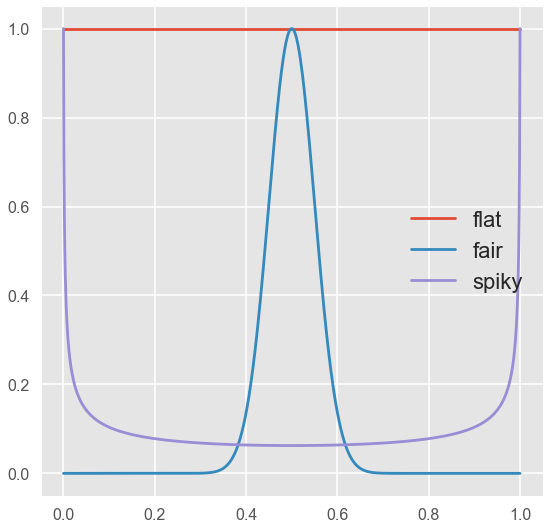

In [15]:
def normalize(f, dx=1.0): # normalize the distribution
    return f / (np.sum(f)*dx) 
def normal(x,mu,sigma):   # normal distributed data
    return 1/(np.sqrt(2*np.pi) * sigma) * np.exp(-(x-mu)**2/(2*sigma**2))
def beta(x,alpha, beta):  # beta distributed data
    return x**alpha*(1-x)**beta

h_real = 0.25 # bias of our coin
hs     = np.linspace(0,1,num=2**10,endpoint=False)[1:] # grid of h values (ignore first and last points)
dh     = hs[1]-hs[0] # grid spacing

flat_prior = normalize(np.ones_like(hs), dh)
fair_prior = normalize(normal(hs, 0.5, 0.05), dh)
spiky_prior= normalize(beta(hs, -0.5, -0.5), dh)

fig, ax = plt.subplots(figsize=(9,9))
for prior,lbl in zip([flat_prior, fair_prior, spiky_prior], ['flat', 'fair', 'spiky']):
    ax.plot(hs, prior/np.max(prior), label=lbl)
ax.legend(fontsize=22)
plt.show()

Computationally, it's easier to work with the logarithm of the posterior $L = \log{p(D\lvert H, I)}$
\begin{align}
p(H \lvert D I ) &\propto p(D \lvert H, I) \cdot p(H\lvert I)\\
p(D \lvert H, I) &\propto H^{R}\left(1-H\right)^{N-R}\\
L \equiv \log{p(D\lvert H, I)}&= R\log{H} + (N-R)\log{(1-H)} + \log{p(H\lvert I)} + C
\end{align}

Let's compute the log-posterior for a series of tosses, from $N=1$ to $N=4096$

In [21]:
random.seed(1234567)
posteriors = []   # will contain the log(p(D|H,I))
last_draw  = []   # result of last coin toss
ntosses    = [0,1,2,3,4,8,16,32,64,128,256,512,1024,2048,4096] 

# generate random data of 4096 coin tosses
data       = random.choice([1, 0], size=ntosses[-1], p=[h_real, 1-h_real]) # heads = 1, tails = 0, p(heads) = h_real, p(tails) = 1-h_real

# compute log-posterior for sub-sequences
for n in ntosses:
    sample      = data[:n] # analyze first n tosses only
    r           = np.sum(sample == 1)
    print(f'{r:5d} heads obtained after {n:5d} coin tosses (or {float(r/n):.3f}%)')

    likelihood  = r*np.log(hs) + (n - r)*np.log(1-hs)        # p(D|H,I) ~ H^R * (1 - H)^(N - R)
    posteriors.append(likelihood + np.log(flat_prior))       # p(H|D,I) ~ p(D|H,I) p(H|I)
    if(n > 0):
        last_draw.append(sample[-1]) 
last_draw.insert(0, 0)

    0 heads obtained after     0 coin tosses (or nan%)
    1 heads obtained after     1 coin tosses (or 1.000%)
    2 heads obtained after     2 coin tosses (or 1.000%)
    3 heads obtained after     3 coin tosses (or 1.000%)
    3 heads obtained after     4 coin tosses (or 0.750%)
    7 heads obtained after     8 coin tosses (or 0.875%)
    9 heads obtained after    16 coin tosses (or 0.562%)
   14 heads obtained after    32 coin tosses (or 0.438%)
   25 heads obtained after    64 coin tosses (or 0.391%)
   42 heads obtained after   128 coin tosses (or 0.328%)
   71 heads obtained after   256 coin tosses (or 0.277%)
  126 heads obtained after   512 coin tosses (or 0.246%)
  266 heads obtained after  1024 coin tosses (or 0.260%)
  530 heads obtained after  2048 coin tosses (or 0.259%)
 1058 heads obtained after  4096 coin tosses (or 0.258%)


We want the distribution to be normalized, 
$
\sum_i p_i= 1
$,
but if we are not carefull we will quickly run into overflow/underflow problems. To avoid this, we work with logarithms all the way, such that

$\begin{align}
p_i^\prime &= \frac{p_i}{\sum_i p_i} \\
\ln{p_i^\prime} &= \ln{p_i} - \ln{\sum_i p_i} \\
&= \ln{p_i} - \ln{\left[\sum_i e^{\ln{p_i}}\right]}
\end{align}$

Now, to evaluate the term $\sum_i p_i = \sum_i e^{\ln{p_i}}$, we compute this as a series of logarithms of sums of exponentiations.

Let $\mathcal{L}(a,b) = \ln{\left(e^{a} + e^{b}\right)}$, such that

$
e^{\mathcal{L}(a,b)} = e^{a} + e^{b}
$

we have

$
\begin{align}
\sum_i p_i &= \sum_i e^{\ln{p_i}} = e^{\ln{p_1}} + e^{\ln{p_2}} + e^{\ln{p_3}} + e^{\ln{p_4}}+\cdots + e^{\ln{p_n}}\\
&= e^{\mathcal{L}(\ln{p_1}, \ln{p_2})} + e^{\ln{p_3}} + e^{\ln{p_4}} + \cdots  + e^{\ln{p_n}}\\
&= e^{\mathcal{L}\left(\mathcal{L}(\ln{p_1}, \ln{p_2}), \ln{p_3}\right)} + e^{\ln{p_4}} + \cdots + e^{\ln{p_n}}\\
&= e^{\mathcal{L}(\cdots\mathcal{L}(\mathcal{L}(\mathcal{L}(\ln{p_1}, \ln{p_2}), \ln{p_3}), \ln{p_4})\cdots ,\ln{p_n})}\\
\ln{\left[\sum_i e^{\ln{p_i}}\right]} &= \mathcal{L}(\cdots\mathcal{L}(\mathcal{L}(\mathcal{L}(\ln{p_1}, \ln{p_2}), \ln{p_3}), \ln{p_4})\cdots ,\ln{p_n})
\end{align}
$

$\mathcal{L}$ corresponds to the numpy function 'logaddexp', and this expression can be computed by applying a reduce operation to the list of log-posteriors.

In [29]:
def get_posteriorpdf(logp): # compute normalized pdf
    normalization = reduce(np.logaddexp, logp) # log of normalization factor, logaddexp(loga,logb) = log(exp(log(a)) + exp(log(b))) = log(a + b)
    return np.exp(logp - normalization)

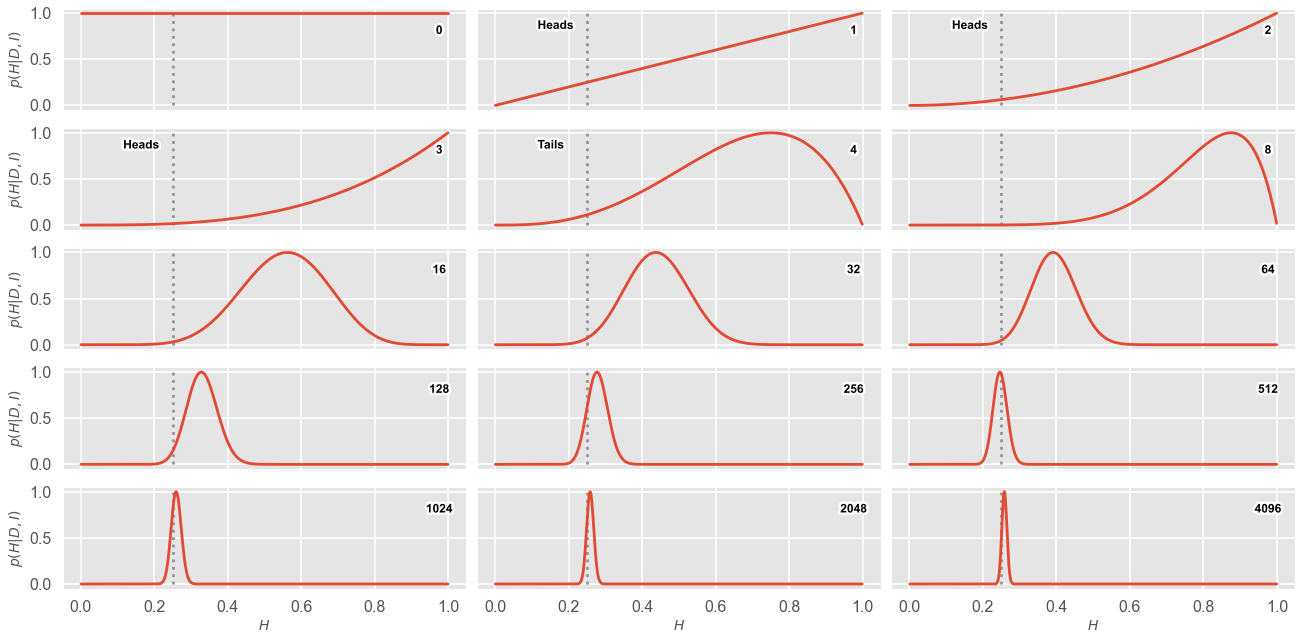

In [30]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18,9), sharex=True, sharey=True)
tags      = ['Tails', 'Heads']
for ax,post,n,last in zip(axes.flatten(), posteriors, ntosses, last_draw):
    pdf = get_posteriorpdf(post)
    ax.plot(hs, pdf/np.max(pdf))
    addtxt(ax, 0.9, 0.75, f'{n:4d}', fs=12, lw=5)
    if n > 0 and n <= 4:
        addtxt(ax, 0.15, 0.8, f'{tags[last]}', fs=12, lw=5)
    ax.vlines(h_real, 0, 1, color='gray', linestyles=':', alpha=0.8)
for ax in axes[-1]:
    ax.set_xlabel(r'$H$', fontsize=14)
for ax in axes[:,0]:
    ax.set_ylabel(r'$p(H| D, I)$', fontsize=14)
fig.tight_layout()

In [33]:
# repeat previous experiment, but now use three different priors, resulting in three different posteriors
random.seed(1234567)
posteriors = []
posteriors_fair = []
posteriors_spiky=[]
ntosses    = [0,1,2,3,4,8,16,32,64,128,256,512,1024,2048,4096]
data       = random.choice([1, 0], size=ntosses[-1], p=[h_real, 1-h_real]) # tail = -1, heads = 1
for n in ntosses:
    sample      = data[:n]
    r           = np.sum(sample == 1)

    likelihood  = r*np.log(hs) + (n - r)*np.log(1-hs)        # p(D|H,I) ~ H^R * (1 - H)^(N - R)
    posteriors.append(likelihood + np.log(flat_prior))       # p(H|D,I) ~ p(D|H,I) p(H|I)
    posteriors_fair.append(likelihood + np.log(fair_prior))
    posteriors_spiky.append(likelihood + np.log(spiky_prior))

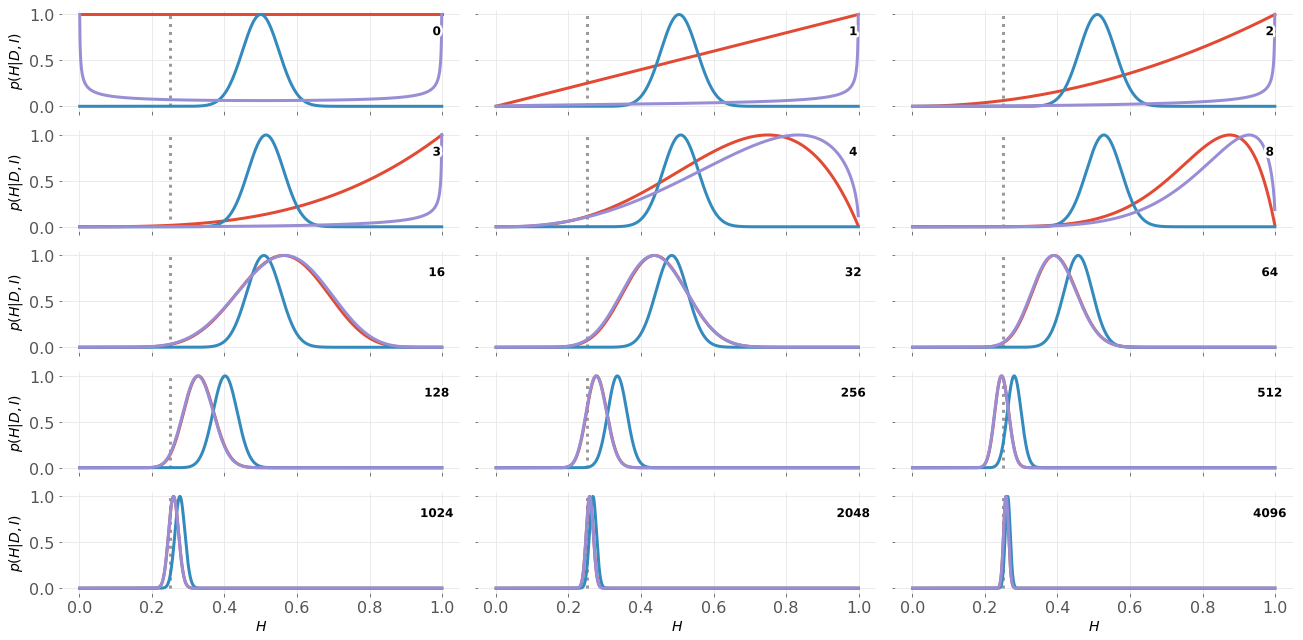

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18,9), sharex=True, sharey=True)
for ax,post,post_fair,post_spiky, n,last in zip(axes.flatten(), posteriors, posteriors_fair, posteriors_spiky, ntosses, last_draw):
    for p in [post, post_fair, post_spiky]:
        pdf = get_posteriorpdf(p)
        ax.plot(hs, pdf/np.max(pdf))
    
    addtxt(ax, 0.9, 0.75, f'{n:4d}', fs=12, lw=5)
    ax.vlines(h_real, 0, 1, color='gray', linestyles=':', alpha=0.8)

for ax in axes[-1]:
    ax.set_xlabel(r'$H$', fontsize=14)
for ax in axes[:,0]:
    ax.set_ylabel(r'$p(H| D, I)$', fontsize=14)
fig.tight_layout()

In [8]:
ndraws = 8
with pm.Model() as model:
    H       = pm.Uniform('H', lower=0, upper=1)
    samples = pm.Bernoulli('samples', p = H, observed=data[:ndraws])

In [9]:
with model:
    trace = pm.sample(10000, init=None, cores=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [H]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:05<00:00, 3943.80draws/s]


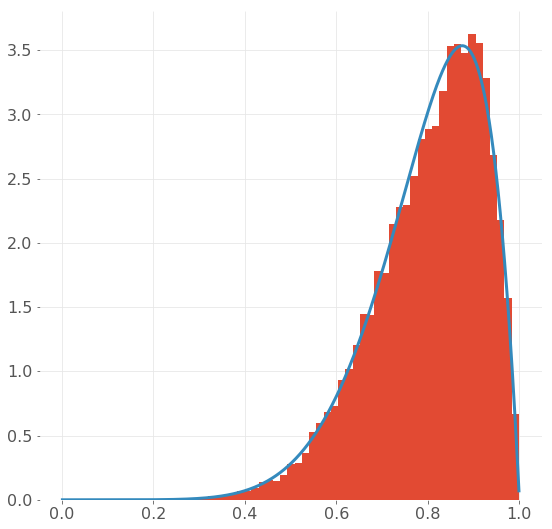

In [10]:
fig, ax = plt.subplots(figsize=(9,9))
ax.hist(trace['H'], density=True, bins=50)

pdf = get_posteriorpdf(posteriors[5])
ax.plot(hs, pdf/np.sum(pdf*dh))
plt.show()

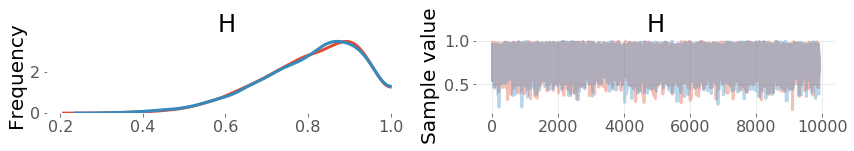

In [11]:
pm.traceplot(trace[100:]);

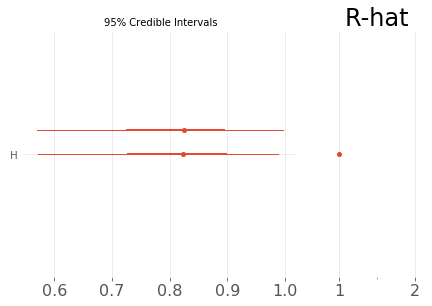

In [12]:
pm.forestplot(trace);

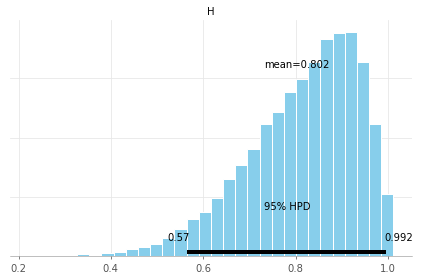

In [13]:
pm.plot_posterior(trace);